In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("stl10_final.csv", header = None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,27639,27640,27641,27642,27643,27644,27645,27646,27647,27648
0,146,143,110,146,143,110,146,143,110,146,...,138,127,119,147,136,122,138,128,93,1
1,129,140,73,124,133,68,138,144,84,144,...,146,128,94,151,130,91,194,164,123,0
2,179,223,114,163,203,104,165,191,103,89,...,124,149,128,114,140,117,104,131,109,1
3,14,18,29,16,21,35,14,21,41,12,...,125,80,18,123,80,18,120,80,18,0
4,147,130,91,200,189,164,127,112,89,68,...,147,131,89,145,129,93,155,138,108,0


In [4]:
X = df.iloc[:, 0:-1].to_numpy()
Y = df.iloc[:, -1].to_numpy()

In [5]:
X = X / 256.0

In [51]:
import timeit

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Optimizer

In [50]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [8]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X), torch.FloatTensor(Y))

In [60]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [40]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 27648.
        self.layer_1 = nn.Linear(27648, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
# simple sgd optimizer, adapted from pytorch official implementation. 

class SGD_Simple(Optimizer):
    
    def __init__(self, params, lr, weight_decay=0.0):
        
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
            
        defaults = dict(lr=lr, weight_decay=weight_decay)
        
        super(SGD_Simple, self).__init__(params, defaults)

    def step(self):

        for group in self.param_groups:
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                    
                p.data.add_(-group['lr'], d_p)

In [45]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [110]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = SGD_Simple(model.parameters(), lr = 0.002)

BinaryClassification(
  (layer_1): Linear(in_features=27648, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [111]:
timelist = []
losslist = []
acclist = []

start_time = timeit.default_timer()

model.train()
for e in range(1, 200+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_time = timeit.default_timer()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    losslist.append(epoch_loss/len(train_loader))
    timelist.append(epoch_time - start_time)
    acclist.append(epoch_acc/len(train_loader))

Epoch 001: | Loss: 0.50147 | Acc: 80.402
Epoch 002: | Loss: 0.44659 | Acc: 83.113
Epoch 003: | Loss: 0.43205 | Acc: 83.279
Epoch 004: | Loss: 0.42176 | Acc: 83.358
Epoch 005: | Loss: 0.41241 | Acc: 83.711
Epoch 006: | Loss: 0.41071 | Acc: 83.730
Epoch 007: | Loss: 0.39902 | Acc: 84.240
Epoch 008: | Loss: 0.39111 | Acc: 84.500
Epoch 009: | Loss: 0.38368 | Acc: 84.353
Epoch 010: | Loss: 0.38201 | Acc: 84.515
Epoch 011: | Loss: 0.36955 | Acc: 84.980
Epoch 012: | Loss: 0.38262 | Acc: 84.765
Epoch 013: | Loss: 0.36439 | Acc: 85.299
Epoch 014: | Loss: 0.36880 | Acc: 84.926
Epoch 015: | Loss: 0.35957 | Acc: 85.265
Epoch 016: | Loss: 0.35657 | Acc: 85.328
Epoch 017: | Loss: 0.36266 | Acc: 85.137
Epoch 018: | Loss: 0.35454 | Acc: 85.417
Epoch 019: | Loss: 0.35374 | Acc: 85.475
Epoch 020: | Loss: 0.34771 | Acc: 85.652
Epoch 021: | Loss: 0.34426 | Acc: 85.750
Epoch 022: | Loss: 0.33981 | Acc: 85.725
Epoch 023: | Loss: 0.34428 | Acc: 85.740
Epoch 024: | Loss: 0.33612 | Acc: 85.902
Epoch 025: | Los

In [89]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer2 = SGD_Simple(model.parameters(), lr = 0.003)

BinaryClassification(
  (layer_1): Linear(in_features=27648, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [90]:
timelist3 = []
losslist3 = []
acclist3 = []

start_time = timeit.default_timer()

model.train()
for e in range(1, 200+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_time = timeit.default_timer()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    losslist3.append(epoch_loss/len(train_loader))
    timelist3.append(epoch_time - start_time)
    acclist3.append(epoch_acc/len(train_loader))

Epoch 001: | Loss: 0.53385 | Acc: 79.765
Epoch 002: | Loss: 0.50491 | Acc: 80.000
Epoch 003: | Loss: 0.48710 | Acc: 80.387
Epoch 004: | Loss: 0.47713 | Acc: 81.642
Epoch 005: | Loss: 0.47090 | Acc: 82.083
Epoch 006: | Loss: 0.46317 | Acc: 82.716
Epoch 007: | Loss: 0.45627 | Acc: 82.936
Epoch 008: | Loss: 0.45199 | Acc: 82.922
Epoch 009: | Loss: 0.44764 | Acc: 83.054
Epoch 010: | Loss: 0.44193 | Acc: 83.196
Epoch 011: | Loss: 0.43603 | Acc: 83.618
Epoch 012: | Loss: 0.43344 | Acc: 83.510
Epoch 013: | Loss: 0.42977 | Acc: 83.544
Epoch 014: | Loss: 0.42471 | Acc: 83.824
Epoch 015: | Loss: 0.42261 | Acc: 83.716
Epoch 016: | Loss: 0.42081 | Acc: 84.049
Epoch 017: | Loss: 0.41585 | Acc: 84.093
Epoch 018: | Loss: 0.41410 | Acc: 84.078
Epoch 019: | Loss: 0.41044 | Acc: 84.466
Epoch 020: | Loss: 0.41091 | Acc: 84.162
Epoch 021: | Loss: 0.40568 | Acc: 84.294
Epoch 022: | Loss: 0.40636 | Acc: 84.279
Epoch 023: | Loss: 0.40361 | Acc: 84.279
Epoch 024: | Loss: 0.39833 | Acc: 84.564
Epoch 025: | Los

In [14]:
def group_product(xs, ys):
    
    return sum([torch.sum(x * y) for (x, y) in zip(xs, ys)])

def normalization(v):
    # normalize a vector
    
    s = group_product(v, v)
    s = s**0.5
    s = s.cpu().item()
    v = [vi / (s + 1e-6) for vi in v]
    return v

In [73]:
class NysHessianpartial():
    
    def __init__(self, rank, rho):
        self.rank = rank
        # rho is the regularization in Nystrom sketch
        self.rho = rho
    
    def get_params_grad(self, model):
        # get parameters and differentiation
        params = []
        grads = []
        for param in model.parameters():
            if not param.requires_grad:
                continue
            params.append(param)
            grads.append(0. if param.grad is None else param.grad + 0.)
        return params, grads
    
    def update_Hessian(self, X_batch, y_batch, model, criterion, device):
        
        shift = 0.001
        # get the model parameters and gradients
        params, gradsH = self.get_params_grad(model)
        # remember the size for each group of parameters
        self.size_vec = [p.size() for p in params]
        # store random gaussian vector to a matrix
        test_matrix = []
        # Hessian vector product
        hv_matrix = []
        
        for i in range(self.rank):
            # generate gaussian random vector
            v = [torch.randn(p.size()).to(device) for p in params]
            # normalize
            v = normalization(v)
            # zero vector to store the shape
            hv_add = [torch.zeros(p.size()).to(device) for p in params]
        
            # update hessian with a subsample batch
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            model.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward(create_graph=True)
            params, gradsH = self.get_params_grad(model)
            # calculate the Hessian vector product
            hv = torch.autograd.grad(gradsH, params, grad_outputs=v,only_inputs=True,retain_graph=True)
            # add initial shift
            for i in range(len(hv)):
                hv_add[i].data = hv[i].data.add_(hv_add[i].data)    
                hv_add[i].data = hv_add[i].data.add_(v[i].data * torch.tensor(shift)) 
            
            # reshape the Hessian vector product into a long vector
            hv_ex = torch.cat([gi.view(-1) for gi in hv_add])
            # reshape the random vector into a long vector
            test_ex = torch.cat([gi.view(-1) for gi in v])
            
            # append long vectors into a large matrix
            hv_matrix.append(hv_ex)
            test_matrix.append(test_ex)
        
        # assemble the large matrix
        hv_matrix_ex = torch.column_stack(hv_matrix)
        test_matrix_ex = torch.column_stack(test_matrix)
        # calculate Omega^T * A * Omega for Cholesky
        choleskytarget = torch.mm(test_matrix_ex.t(), hv_matrix_ex)
        # perform Cholesky, if fails, do eigendecomposition
        # the new shift is the abs of smallest eigenvalue (negative) plus the original shift
        try:
            C_ex = torch.linalg.cholesky(choleskytarget)
        except:
            # eigendecomposition, eigenvalues and eigenvector matrix
            eigs, eigvectors = torch.linalg.eigh(choleskytarget)
            shift = shift + torch.abs(torch.min(eigs))
            # add shift to eigenvalues
            eigs = eigs + shift
            # put back the matrix for Cholesky by eigenvector * eigenvalues after shift * eigenvector^T 
            C_ex = torch.linalg.cholesky(torch.mm(eigvectors, torch.mm(torch.diag(eigs), eigvectors.T)))
        
        # triangular solve
        B_ex = torch.linalg.solve_triangular(C_ex, hv_matrix_ex, upper = False, left = False)
        # SVD
        U, S, V = torch.linalg.svd(B_ex, full_matrices = False)
        self.U = U
        self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))
        

In [84]:
class NysHessianOpt(Optimizer):
    r"""Implements NysHessian.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        rank (int): sketch rank
        rho: regularization
    """
    def __init__(self, params, lr, rank = 100, rho = 0.5):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        # initialize the optimizer    
        defaults = dict(lr=lr, rank = rank, rho = rho)
        self.nysh = NysHessianpartial(rank, rho)
        super(NysHessianOpt, self).__init__(params, defaults)
         
    def step(self):
        # one step update
        for group in self.param_groups:
            rho = group['rho']
            # compute gradient as a long vector
            g = torch.cat([p.grad.view(-1) for p in group['params']])
            # calculate the search direction by Nystrom sketch and solve
            UTg = torch.mv(self.nysh.U.t(), g) 
            g_new = torch.mv(self.nysh.U, (self.nysh.S + rho).reciprocal() * UTg) + g / rho - torch.mv(self.nysh.U, UTg) / rho            
            ls = 0
            # update model parameters
            for p in group['params']:
                gp = g_new[ls:ls+torch.numel(p)].view(p.shape)
                ls += torch.numel(p)
                p.data.add_(-group['lr'] * gp)

In [92]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr = 0.003)
optimizer = NysHessianOpt(model.parameters(), lr = 0.003)

BinaryClassification(
  (layer_1): Linear(in_features=27648, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [86]:
hes_interval = 150
# update Hessian and Nystrom sketch every couple of steps
hes_iter = 0

timelist2 = []
losslist2 = []
acclist2 = []

start_time = timeit.default_timer()

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:
        
        if hes_iter % hes_interval == 0:
            # update Hessian and sketch
            optimizer.nysh.update_Hessian(X_batch, y_batch, model, criterion, device)
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        hes_iter += 1
        epoch_time = timeit.default_timer()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    losslist2.append(epoch_loss/len(train_loader))
    timelist2.append(epoch_time - start_time)
    acclist2.append(epoch_acc/len(train_loader))

<ipython-input-73-436a86fe9bc1>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))


Epoch 001: | Loss: 0.51986 | Acc: 79.304
Epoch 002: | Loss: 0.47901 | Acc: 82.157
Epoch 003: | Loss: 0.46580 | Acc: 82.436
Epoch 004: | Loss: 0.45364 | Acc: 82.858
Epoch 005: | Loss: 0.44338 | Acc: 83.176
Epoch 006: | Loss: 0.43220 | Acc: 83.569
Epoch 007: | Loss: 0.42305 | Acc: 83.711
Epoch 008: | Loss: 0.41242 | Acc: 84.152
Epoch 009: | Loss: 0.40536 | Acc: 84.475
Epoch 010: | Loss: 0.39963 | Acc: 84.642
Epoch 011: | Loss: 0.39431 | Acc: 84.652
Epoch 012: | Loss: 0.38674 | Acc: 84.917
Epoch 013: | Loss: 0.38082 | Acc: 85.147
Epoch 014: | Loss: 0.37316 | Acc: 85.353
Epoch 015: | Loss: 0.36674 | Acc: 85.471
Epoch 016: | Loss: 0.35965 | Acc: 85.804
Epoch 017: | Loss: 0.35428 | Acc: 86.020
Epoch 018: | Loss: 0.34705 | Acc: 86.245
Epoch 019: | Loss: 0.33998 | Acc: 86.279
Epoch 020: | Loss: 0.33140 | Acc: 86.735
Epoch 021: | Loss: 0.32574 | Acc: 87.010
Epoch 022: | Loss: 0.31754 | Acc: 87.275
Epoch 023: | Loss: 0.31022 | Acc: 87.407
Epoch 024: | Loss: 0.30260 | Acc: 87.892
Epoch 025: | Los

KeyboardInterrupt: 

In [56]:
import matplotlib.pyplot as plt

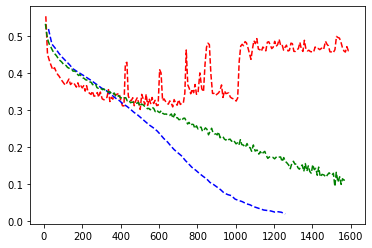

In [99]:
plt.plot(timelist, losslist, 'r--', timelist2, losslist2, 'b--', timelist3, losslist3, 'g--')
plt.show()

In [101]:
class NysHessianPSGD(Optimizer):
    r"""Implements NysHessian.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        rank (int): sketch rank
        rho: regularization
    """
    def __init__(self, params, lr, rank = 100, rho = 0.5):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        # initialize the optimizer    
        defaults = dict(lr=lr, rank = rank, rho = rho)
        self.nysh = NysHessianpartial(rank, rho)
        super(NysHessianPSGD, self).__init__(params, defaults)
         
    def step(self):
        # one step update
        for group in self.param_groups:
            rho = group['rho']
            # compute gradient as a long vector
            g = torch.cat([p.grad.view(-1) for p in group['params']])
            # calculate the search direction by Nystrom preconditioned gradient descent
            UTg = torch.mv(self.nysh.U.t(), g) 
            g_new = torch.mv(self.nysh.U, (self.nysh.S + rho).reciprocal() * UTg) * (torch.min(self.nysh.S) + rho) + g - torch.mv(self.nysh.U, UTg)            
            ls = 0
            # update model parameters
            for p in group['params']:
                gp = g_new[ls:ls+torch.numel(p)].view(p.shape)
                ls += torch.numel(p)
                p.data.add_(-group['lr'] * gp)

In [102]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr = 0.003)
optimizer = NysHessianPSGD(model.parameters(), lr = 0.003)

BinaryClassification(
  (layer_1): Linear(in_features=27648, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [103]:
hes_interval = 150
# update Hessian and Nystrom sketch every couple of steps
hes_iter = 0

timelist4 = []
losslist4 = []
acclist4 = []

start_time = timeit.default_timer()

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:
        
        if hes_iter % hes_interval == 0:
            # update Hessian and sketch
            optimizer.nysh.update_Hessian(X_batch, y_batch, model, criterion, device)
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        hes_iter += 1
        epoch_time = timeit.default_timer()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    losslist4.append(epoch_loss/len(train_loader))
    timelist4.append(epoch_time - start_time)
    acclist4.append(epoch_acc/len(train_loader))

<ipython-input-73-436a86fe9bc1>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))


Epoch 001: | Loss: 0.53567 | Acc: 80.088
Epoch 002: | Loss: 0.49723 | Acc: 80.402
Epoch 003: | Loss: 0.48008 | Acc: 81.784
Epoch 004: | Loss: 0.47290 | Acc: 82.181
Epoch 005: | Loss: 0.46328 | Acc: 82.833
Epoch 006: | Loss: 0.45847 | Acc: 82.882
Epoch 007: | Loss: 0.45208 | Acc: 82.971
Epoch 008: | Loss: 0.44678 | Acc: 83.147
Epoch 009: | Loss: 0.44129 | Acc: 83.265
Epoch 010: | Loss: 0.43574 | Acc: 83.422
Epoch 011: | Loss: 0.42908 | Acc: 83.662
Epoch 012: | Loss: 0.42282 | Acc: 83.897
Epoch 013: | Loss: 0.42031 | Acc: 83.882
Epoch 014: | Loss: 0.41426 | Acc: 83.966
Epoch 015: | Loss: 0.40931 | Acc: 84.333
Epoch 016: | Loss: 0.40413 | Acc: 84.505
Epoch 017: | Loss: 0.40106 | Acc: 84.534
Epoch 018: | Loss: 0.39899 | Acc: 84.485
Epoch 019: | Loss: 0.39542 | Acc: 84.623
Epoch 020: | Loss: 0.39061 | Acc: 84.804
Epoch 021: | Loss: 0.38818 | Acc: 84.936
Epoch 022: | Loss: 0.38549 | Acc: 85.015
Epoch 023: | Loss: 0.38393 | Acc: 85.083
Epoch 024: | Loss: 0.37869 | Acc: 85.324
Epoch 025: | Los

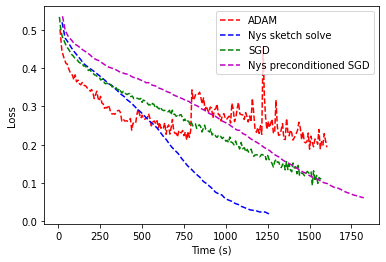

In [114]:
plt.ylabel("Loss")
plt.xlabel("Time (s)")
plt.plot(timelist, losslist, 'r--', timelist2, losslist2, 'b--', timelist3, losslist3, 'g--', timelist4, losslist4, 'm--')
plt.legend(["ADAM", "Nys sketch solve", "SGD", "Nys preconditioned SGD"])
plt.show()

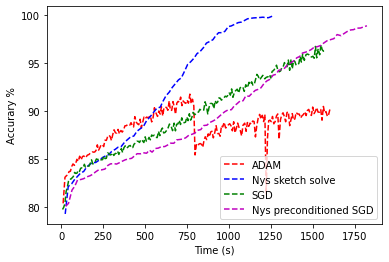

In [115]:
plt.ylabel("Accurary %")
plt.xlabel("Time (s)")
plt.plot(timelist, acclist, 'r--', timelist2, acclist2, 'b--', timelist3, acclist3, 'g--', timelist4, acclist4, 'm--')
plt.legend(["ADAM", "Nys sketch solve", "SGD", "Nys preconditioned SGD"])
plt.show()

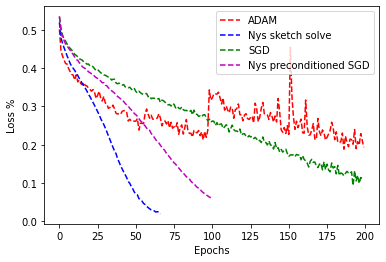

In [117]:
plt.ylabel("Loss %")
plt.xlabel("Epochs")
plt.plot(losslist, 'r--', losslist2, 'b--', losslist3, 'g--', losslist4, 'm--')
plt.legend(["ADAM", "Nys sketch solve", "SGD", "Nys preconditioned SGD"])
plt.show()

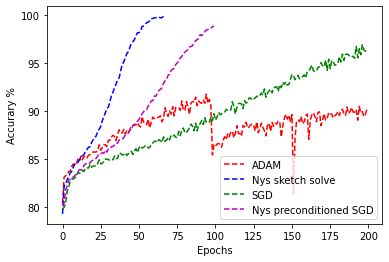

In [116]:
plt.ylabel("Accurary %")
plt.xlabel("Epochs")
plt.plot(acclist, 'r--', acclist2, 'b--', acclist3, 'g--', acclist4, 'm--')
plt.legend(["ADAM", "Nys sketch solve", "SGD", "Nys preconditioned SGD"])
plt.show()

In [ ]:
# try NOCEDAL stuff, see whether work
# problem not interpolation, 
# under parameterized network, much much less network
# ask chengrun about
# sketchy sgd 